## Prompts Evaluation with Prompt Management & Prompt Flows

In this example, we'll explore how to evaluate prompts using a combination of Prompt Management and Prompt Flows in Amazon Bedrock.

Evaluating prompts is an essential step in the prompt lifecycle. Using LLM-as-a-judge for validating your prompts according to your own criteria allows you to efficiently quantify the prompts quality for optimization at scale.


<img src="./images/prompt_eval_diagram.png" width="30%">


[Amazon Bedrock Prompt Management](https://docs.aws.amazon.com/bedrock/latest/userguide/prompt-management.html) streamlines the creation, evaluation, deployment, and sharing of prompts in the Amazon Bedrock console and via APIs in the SDK. This feature helps developers and business users obtain the best responses from foundation models for their specific use cases.

[Amazon Bedrock Prompt Flows](https://docs.aws.amazon.com/bedrock/latest/userguide/flows.html) allows you to easily link multiple foundation models (FMs), prompts, and other AWS services, reducing development time and effort. It introduces a visual builder in the Amazon Bedrock console and a new set of APIs in the SDK, that simplifies the creation of complex generative AI workflows.

Let's start by making sure we have the lastest version of the Amazon Bedrock SDK, importing the libraries, and setting-up the client.

In [1]:
# Only run this the first time...
!pip3 install boto3 botocore matplotlib -qU

In [2]:
import boto3
from datetime import datetime
import json

Note the Prompt Management and Flows features are part of the Bedrock Agent SDK.

In [160]:
### Adjust with your preferred region accordingly:
region = "us-east-1"

bedrock_agent = boto3.client(service_name = "bedrock-agent", region_name = region)

### Adjust with your preferred model IDs for invocations and evaluation - Note some models are only available in certain regions:
modelInvokeId = "amazon.titan-text-premier-v1:0"
modelEvalId = "anthropic.claude-3-sonnet-20240229-v1:0"


### Evaluation Prompt

Let's create our sample evaluation prompt by leveraging on Prompt Management for Amazon Bedrock. Here, you can adjust the sample prompt template and evaluation criteria provided according to your specific needs.

In [182]:
response = bedrock_agent.create_prompt(
    name = f"prompt-evaluator",
    description = "Prompt template for evaluating prompt responses with LLM-as-a-judge",
    variants = [
        {
            "inferenceConfiguration": {
            "text": {
                "maxTokens": 2000,
                "temperature": 0,
            }
            },
            "modelId": modelEvalId,
            "name": "variantOne",
            "templateConfiguration": {
                "text": {
                    "inputVariables": [
                        {
                            "name": "input"
                        },
                        {
                            "name": "output"
                        }
                    ],
                    "text": """
You're an evaluator for the prompts and answers provided by a generative AI model. Consider the input prompt in \
the <input> tags, the output answer in the <output> tags, the prompt evaluation criteria in the <prompt_criteria> tags, \
and the answer evaluation criteria in the <answer_criteria> tags.

<input>
{{input}}
</input>

<output>
{{output}}
</output>

<prompt_criteria>
- The prompt should be clear, direct, and detailed.
- The question, task, or goal should be well explained and be grammatically correct.
- The prompt is better if containing examples.
- The prompt is better if specifies a role or sets a context.
- The prompt is better if provides details about the format and tone of the expected answer.
</prompt_criteria>

<answer_criteria>
- The answers should be correct, well structured, and technically complete.
- The answers should not have any hallucinations, made up content, or toxic content.
- The answer should be grammatically correct.
- The answer should be fully aligned with the question or instruction in the prompt.
</answer_criteria>

Evaluate the answer the generative AI model provided in the <output> with a score from 0 to 100 according to the <answer_criteria> provided; \
any hallucinations, even if small, should dramatically impact the evaluation score.
Also evaluate the prompt passed to that generative AI model provided in the <input> with a score from 0 to 100 according to the <prompt_criteria> provided.
Respond only with a JSON having:
- An 'answer-score' key with the score number you evaluated the answer with.
- A 'prompt-score' key with the score number you evaluated the prompt with.
- A 'justification' key with a justification for the two evaluations you provided to the answer and the prompt; make sure to explicitely include any errors or hallucinations in this part.
- An 'input' key with the content of the <input> tags.
- An 'output' key with the content of the <output> tags.
- A 'prompt-recommendations' key with recommendations for improving the prompt based on the evaluations performed.
Skip any preamble or any other text apart from the JSON in your answer.
                    """
                }
            },
            "templateType": "TEXT"
        }
    ],
    defaultVariant = "variantOne"
)
print(json.dumps(response, indent=2, default=str))
promptEvalId = response["id"]
promptEvalArn = response["arn"]
promptEvalName = response["name"]
print(f"Prompt ID: {promptEvalId}\nPrompt ARN: {promptEvalArn}\nPrompt Name: {promptEvalName}")

{
  "ResponseMetadata": {
    "RequestId": "ae24bc6b-8d4d-473d-9124-85945468e28c",
    "HTTPStatusCode": 201,
    "HTTPHeaders": {
      "date": "Mon, 29 Jul 2024 13:46:12 GMT",
      "content-type": "application/json",
      "content-length": "5148",
      "connection": "keep-alive",
      "x-amzn-requestid": "ae24bc6b-8d4d-473d-9124-85945468e28c",
      "x-amz-apigw-id": "brV9pEo9oAMEk_g=",
      "x-amzn-trace-id": "Root=1-66a79d23-65a9f82a152e0cf37954aa13"
    },
    "RetryAttempts": 0
  },
  "arn": "arn:aws:bedrock:us-east-1:889960878219:prompt/95ZBT5J1ZO",
  "createdAt": "2024-07-29 13:46:11.913802+00:00",
  "defaultVariant": "variantOne",
  "description": "Prompt template for evaluating prompt responses with LLM-as-a-judge",
  "id": "95ZBT5J1ZO",
  "name": "prompt-evaluator",
  "updatedAt": "2024-07-29 13:46:11.913802+00:00",
  "variants": [
    {
      "inferenceConfiguration": {
        "text": {
          "maxTokens": 2000,
          "temperature": 0.0
        }
      },
     

Now that we have a draft prompt, we can create a version from it.

In [183]:
response = bedrock_agent.create_prompt_version(
    promptIdentifier = promptEvalId
)
print(json.dumps(response, indent=2, default=str))

{
  "ResponseMetadata": {
    "RequestId": "95b29cc5-e77e-406a-94d0-3d2f3d7281c5",
    "HTTPStatusCode": 201,
    "HTTPHeaders": {
      "date": "Mon, 29 Jul 2024 13:46:13 GMT",
      "content-type": "application/json",
      "content-length": "5062",
      "connection": "keep-alive",
      "x-amzn-requestid": "95b29cc5-e77e-406a-94d0-3d2f3d7281c5",
      "x-amz-apigw-id": "brV96HzLIAMEVAA=",
      "x-amzn-trace-id": "Root=1-66a79d25-248191ce2468df2d2fcf01fd"
    },
    "RetryAttempts": 0
  },
  "arn": "arn:aws:bedrock:us-east-1:889960878219:prompt/95ZBT5J1ZO:1",
  "createdAt": "2024-07-29 13:46:13.655818+00:00",
  "defaultVariant": "variantOne",
  "id": "95ZBT5J1ZO",
  "name": "prompt-evaluator",
  "updatedAt": "2024-07-29 13:46:13.655818+00:00",
  "variants": [
    {
      "inferenceConfiguration": {
        "text": {
          "maxTokens": 2000,
          "temperature": 0.0
        }
      },
      "modelId": "anthropic.claude-3-sonnet-20240229-v1:0",
      "name": "variantOne",
   

### Evaluation Flow

Now that we have our evaluation prompt, we can work on a workflow for running the evaluations with it. For this we'll rely on Prompt Flows for Amazon Bedrock.

Let's create a simple flow that will invoke a given model with our input prompts for obtaining the outputs or responses, and then load the evaluation prompt from our catalog for obtaining the evaluation score.

<img src="./images/prompt_eval_flow.png" width="60%">

***Pre-requisite: For using Flows you need to make sure you have the proper AWS IAM permissions in place. You can check details in the [How Prompt Flows for Amazon Bedrock works](https://docs.aws.amazon.com/bedrock/latest/userguide/flows-how-it-works.html) documentation.***

In [184]:
######## REPLACE WITH YOUR AWS IAM ROLE WITH FLOWS FOR BEDROCK PERMISSIONS ########
flowRole = '{REPLACE-WITH-YOUR-AWS-IAM-ROLE-ARN}'

In [185]:
response = bedrock_agent.create_flow(
    name = f"prompt-eval-flow",
    description = "Prompt Flow for evaluating prompts with LLM-as-a-judge.",
    executionRoleArn = flowRole,
    definition = {
        "nodes": [
          {
            "name": "Start",
            "type": "Input",
            "configuration": {
              "input": {}
            },
            "outputs": [
              {
                "name": "document",
                "type": "String"
              }
            ],
          },
          {
            "name": "End",
            "type": "Output",
            "configuration": {
              "output": {}
            },
            "inputs": [
              {
                "expression": "$.data",
                "name": "document",
                "type": "String"
              }
            ],
          },
          {
            "name": "Invoke",
            "type": "Prompt",
            "configuration": {
              "prompt": {
                "sourceConfiguration": {
                  "inline": {
                    "inferenceConfiguration": {
                      "text": {
                        "maxTokens": 2000,
                        "temperature": 0,
                      }
                    },
                    "modelId": modelInvokeId,
                    "templateConfiguration": {
                      "text": {
                        "inputVariables": [
                          {
                            "name": "input"
                          }
                        ],
                        "text": "{{input}}"
                      }
                    },
                    "templateType": "TEXT"
                  }
                }
              }
            },
            "inputs": [
              {
                "expression": "$.data",
                "name": "input",
                "type": "String"
              }
            ],
            "outputs": [
              {
                "name": "modelCompletion",
                "type": "String"
              }
            ],
          },
          {
            "name": "Evaluate",
            "type": "Prompt",
            "configuration": {
              "prompt": {
                "sourceConfiguration": {
                  "resource": {
                    "promptArn": promptEvalArn
                  }
                }
              }
            },
            "inputs": [
              {
                "expression": "$.data",
                "name": "input",
                "type": "String"
              },
              {
                "expression": "$.data",
                "name": "output",
                "type": "String"
              }
            ],
            "outputs": [
              {
                "name": "modelCompletion",
                "type": "String"
              }
            ],
          }
        ],
        "connections": [
          {
            "name": "StartToInvoke",
            "source": "Start",
            "target": "Invoke",
            "type": "Data",
            "configuration": {
              "data": {
                "sourceOutput": "document",
                "targetInput": "input"
              }
            },
          },
          {
            "name": "InvokeToEvaluate",
            "source": "Invoke",
            "target": "Evaluate",
            "type": "Data",
            "configuration": {
              "data": {
                "sourceOutput": "modelCompletion",
                "targetInput": "output"
              }
            },
          },
          {
            "name": "StartToEvaluate",
            "source": "Start",
            "target": "Evaluate",
            "type": "Data",
            "configuration": {
              "data": {
                "sourceOutput": "document",
                "targetInput": "input"
              }
            },
          },
          {
            "name": "EvaluateToEnd",
            "source": "Evaluate",
            "target": "End",
            "type": "Data",
            "configuration": {
              "data": {
                "sourceOutput": "modelCompletion",
                "targetInput": "document"
              }
            },
          }
        ]
    }
)
print(json.dumps(response, indent=2, default=str))
flowEvalId = response["id"]
flowEvalArn = response["arn"]
flowEvalName = response["name"]
print(f"Flow ID: {flowEvalId}\nFlow ARN: {flowEvalArn}\nFlow Name: {flowEvalName}")

{
  "ResponseMetadata": {
    "RequestId": "5c4a7f1c-1f2e-4b82-9297-a9864b4b791e",
    "HTTPStatusCode": 201,
    "HTTPHeaders": {
      "date": "Mon, 29 Jul 2024 13:46:15 GMT",
      "content-type": "application/json",
      "content-length": "2104",
      "connection": "keep-alive",
      "x-amzn-requestid": "5c4a7f1c-1f2e-4b82-9297-a9864b4b791e",
      "x-amz-apigw-id": "brV-NEgRIAMEIZA=",
      "x-amzn-trace-id": "Root=1-66a79d27-043125f415a52106785cbc51"
    },
    "RetryAttempts": 0
  },
  "arn": "arn:aws:bedrock:us-east-1:889960878219:flow/TSACPWH43X",
  "createdAt": "2024-07-29 13:46:15.540663+00:00",
  "definition": {
    "connections": [
      {
        "configuration": {
          "data": {
            "sourceOutput": "document",
            "targetInput": "input"
          }
        },
        "name": "StartToInvoke",
        "source": "Start",
        "target": "Invoke",
        "type": "Data"
      },
      {
        "configuration": {
          "data": {
            "sou

Now that we have our first flow, we can prepare it. This basically builds and validates our flow.

In [186]:
response = bedrock_agent.prepare_flow(
    flowIdentifier = flowEvalId
)
print(json.dumps(response, indent=2, default=str))

{
  "ResponseMetadata": {
    "RequestId": "88f600f2-b011-48df-ab84-62b59a365ca1",
    "HTTPStatusCode": 202,
    "HTTPHeaders": {
      "date": "Mon, 29 Jul 2024 13:46:17 GMT",
      "content-type": "application/json",
      "content-length": "40",
      "connection": "keep-alive",
      "x-amzn-requestid": "88f600f2-b011-48df-ab84-62b59a365ca1",
      "x-amz-apigw-id": "brV-fEUZoAMEnkw=",
      "x-amzn-trace-id": "Root=1-66a79d29-2381500b066c7edc3bc2068b"
    },
    "RetryAttempts": 0
  },
  "id": "TSACPWH43X",
  "status": "Preparing"
}


We can now get the flow to double-check the "status" is "prepared", otherwise go back to the previous steps for solving any issues.

In [187]:
response = bedrock_agent.get_flow(
    flowIdentifier = flowEvalId
)
print("Status:", response["status"])

Status: Prepared


Let's create a version from our draft flow. Note flow versions are read-only, meaning these cannot be modified once created as they're intended for using in production. If you need to make changes to a flow you can update your draft.

In [188]:
response = bedrock_agent.create_flow_version(
    flowIdentifier = flowEvalId
)
print(json.dumps(response, indent=2, default=str))

{
  "ResponseMetadata": {
    "RequestId": "37851bc6-75b7-43fd-b41a-2ffd91648e85",
    "HTTPStatusCode": 201,
    "HTTPHeaders": {
      "date": "Mon, 29 Jul 2024 13:46:20 GMT",
      "content-type": "application/json",
      "content-length": "1983",
      "connection": "keep-alive",
      "x-amzn-requestid": "37851bc6-75b7-43fd-b41a-2ffd91648e85",
      "x-amz-apigw-id": "brV--ENkIAMEYyQ=",
      "x-amzn-trace-id": "Root=1-66a79d2c-32cee87c4138275171ce0310"
    },
    "RetryAttempts": 0
  },
  "arn": "arn:aws:bedrock:us-east-1:889960878219:flow/TSACPWH43X",
  "createdAt": "2024-07-29 13:46:20.450472+00:00",
  "definition": {
    "connections": [
      {
        "configuration": {
          "data": {
            "sourceOutput": "document",
            "targetInput": "input"
          }
        },
        "name": "StartToInvoke",
        "source": "Start",
        "target": "Invoke",
        "type": "Data"
      },
      {
        "configuration": {
          "data": {
            "sou

We can also create flow alises, so that we can point our application front-ends and any other integrations to these. This allows creating new versions without impacting our service.

In [189]:
response = bedrock_agent.create_flow_alias(
    flowIdentifier = flowEvalId,
    name = flowEvalName,
    description = "Alias for my prompt evaluation flow",
    routingConfiguration = [
        {
            "flowVersion": "1"
        }
    ]
)
print(json.dumps(response, indent=2, default=str))
flowEvalAliasId = response['id']

{
  "ResponseMetadata": {
    "RequestId": "57eb4764-0c68-4691-863f-52c70d93556d",
    "HTTPStatusCode": 201,
    "HTTPHeaders": {
      "date": "Mon, 29 Jul 2024 13:46:22 GMT",
      "content-type": "application/json",
      "content-length": "334",
      "connection": "keep-alive",
      "x-amzn-requestid": "57eb4764-0c68-4691-863f-52c70d93556d",
      "x-amz-apigw-id": "brV_OGxYIAMEPzQ=",
      "x-amzn-trace-id": "Root=1-66a79d2d-67041b90368b50fd7514b417"
    },
    "RetryAttempts": 0
  },
  "arn": "arn:aws:bedrock:us-east-1:889960878219:flow/TSACPWH43X/alias/D4APVOJWPD",
  "createdAt": "2024-07-29 13:46:22.029102+00:00",
  "description": "Alias for my prompt evaluation flow",
  "flowId": "TSACPWH43X",
  "id": "D4APVOJWPD",
  "name": "prompt-eval-flow",
  "routingConfiguration": [
    {
      "flowVersion": "1"
    }
  ],
  "updatedAt": "2024-07-29 13:46:22.029102+00:00"
}


### Testing the Evaluation Flow

Now that we have our prompt evaluation flow, we can test it with a few invocations. For this we'll rely on the Bedrock Agent Runtime SDK.

You can invoke flows from any application front-end or your own systems as required. It effectively exposes all the logic of your flow through an Agent Endpoint API.

In [190]:
bedrock_agent_runtime = boto3.client(service_name = 'bedrock-agent-runtime', region_name = region)

Let's create a handy function for running the evaluation against a given prompt...

In [191]:
def evaluatePrompt(prompt):
    response = bedrock_agent_runtime.invoke_flow(
        flowIdentifier = flowEvalId,
        flowAliasIdentifier = flowEvalAliasId,
        inputs = [
            { 
                "content": { 
                    "document": prompt
                },
                "nodeName": "Start",
                "nodeOutputName": "document"
            }
        ]
    )
    event_stream = response["responseStream"]
    for event in event_stream:
        #print(json.dumps(event, indent=2, ensure_ascii=False))
        if "flowOutputEvent" in event:
            evalResponse = json.loads(event["flowOutputEvent"]["content"]["document"])
    if evalResponse:
        evalResponse["modelInvoke"] = modelInvokeId
        evalResponse["modelEval"] = modelEvalId
        #print(json.dumps(evalResponse, indent=2, default=str))
        return evalResponse

We can test with a sample prompt, and visualize the results...

In [192]:
evaluatePrompt("What is cloud computing in a single paragraph?")

{'answer-score': 95,
 'prompt-score': 90,
 'justification': 'The answer provides a clear and comprehensive explanation of cloud computing in a single paragraph, covering key aspects such as the delivery model, benefits, and challenges. It is well-structured, grammatically correct, and aligns with the prompt. No hallucinations or made-up content were detected. The prompt is clear, direct, and well-explained, but it could be improved by providing more details on the expected format, tone, or context of the answer.',
 'input': 'What is cloud computing in a single paragraph?',
 'output': 'Cloud computing is a model for delivering information technology services where resources are retrieved from the internet through web-based tools.  It allows users to access computing resources and services on-demand, without the need for owning or maintaining physical infrastructure.  Cloud computing services are typically provided by third-party vendors and can include infrastructure, platform, and soft

----------

### Prompt Evaluation at Scale

Now that we have a flow that is able to evaluate our prompt, we can programmatically extend this for running against a full dataset of prompts at scale. For this, you can either leverage on a dataset stored in an Amazon S3 bucket, or load a file locally like we do in this example notebook.

In the same way, you can write the results in another file in Amazon S3, or visualize it locally like we do in this example notebook.

For our example, let's load a sample dataset with 4 simple prompts...

In [193]:
# Read prompts dataset file locally

import json
promptsDataset = []
with open('prompts_dataset.jsonl') as f:
    for line in f:
        promptsDataset.append(json.loads(line))

if promptsDataset:
    for i, j in enumerate(promptsDataset):
        print(f'{i+1}. {j["input"]}')

1. What is cloud computing in a single paragraph?
2. Act as a Solutions Architect and explain what is cloud computing. Answer with a single and technical paragraph.
3. Act as a Solutions Architect and explain what is cloud computing. Answer with a single and technical paragraph, considering the following example: 'What is a database?' 'A database is a structured collection of data organized in a way that facilitates efficient storage, retrieval, modification, and management of information. It consists of one or more tables, each containing rows (records) and columns (fields) that store specific types of data. Databases employ a database management system (DBMS) software that provides tools for defining, creating, maintaining, and controlling access to the data, ensuring data integrity, security, and consistency. Databases are designed to support various operations, such as querying, sorting, indexing, and data manipulation, enabling efficient data processing and analysis for applicatio

We can now evaluate each prompt in our dataset with the function we created before...

In [194]:
from datetime import datetime
if promptsDataset:
    results = []
    for i, j in enumerate(promptsDataset):
        print(f"{datetime.now().strftime('%H:%M:%S')} - Evaluating prompt {i+1} of {len(promptsDataset)}...")
        try:
            results.append(evaluatePrompt(j["input"]))
        except Exception as e:
            print(f"Error evaluating prompt {i+1}: {e}")
            results.append({"error": str(e)})
    print("All prompts evaluated.")

15:47:08 - Evaluating prompt 1 of 4...
15:47:17 - Evaluating prompt 2 of 4...
15:47:28 - Evaluating prompt 3 of 4...
15:47:43 - Evaluating prompt 4 of 4...
All prompts evaluated.


Let's review the results of the evaluations...

In [195]:
for i in results:
    print(json.dumps(i, indent=2, ensure_ascii=False))

{
  "answer-score": 95,
  "prompt-score": 90,
  "justification": "The answer provides a clear and comprehensive explanation of cloud computing, covering key aspects such as the delivery model, benefits, and challenges. It is well-structured, grammatically correct, and aligns with the prompt. No hallucinations or factual errors were detected. The prompt is clear, direct, and explains the task well. However, it could be improved by providing more context or specifying the desired tone or format of the answer.",
  "input": "What is cloud computing in a single paragraph?",
  "output": "Cloud computing is a model for delivering information technology services where resources are retrieved from the internet through web-based tools.  It allows users to access computing resources and services on-demand, without the need for owning or maintaining physical infrastructure.  Cloud computing services are typically provided by third-party vendors and can include infrastructure, platform, and softwar

We can also create a graph with the scores...

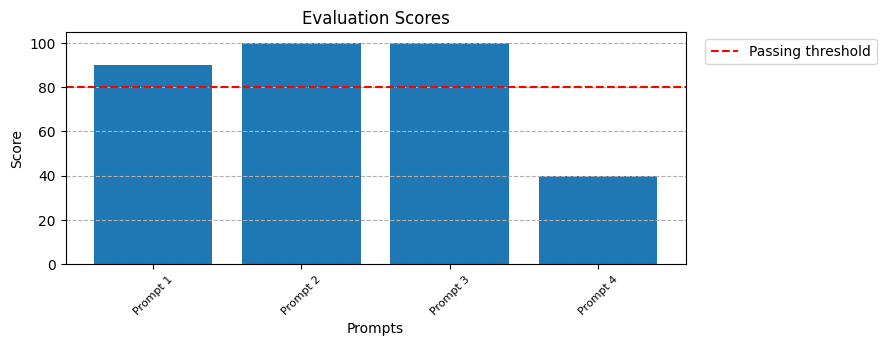

In [196]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the scores from the data
scores = [result['prompt-score'] for result in results]

# Create a list of labels for the x-axis
labels = [f"Prompt {i+1}" for i in range(len(scores))]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Create the bar plot
ax.bar(labels, scores)

# Set the title and axis labels
ax.set_title("Evaluation Scores", fontsize=12)
ax.set_xlabel("Prompts", fontsize=10)
ax.set_ylabel("Score", fontsize=10)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, fontsize=8)

# Add grid lines
ax.grid(axis='y', linestyle='--')

# Adjust the spacing between subplots
plt.subplots_adjust(bottom=0.3)

# Add a horizontal line at score 80
ax.axhline(y=80, color='r', linestyle='--', label='Passing threshold')

# Add a legend
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Show the plot
plt.show()

---

### Cleaning-up Resources (optional)

Before leaving, here's how to delete the resources that we've created.

In [ ]:
response = bedrock_agent.delete_flow_alias(
    flowIdentifier = flowEvalId,
    aliasIdentifier = flowEvalAliasId
)
print(json.dumps(response, indent=2, default=str))

In [ ]:
response = bedrock_agent.delete_flow_version(
    flowIdentifier = flowEvalId,
    flowVersion = '1'
)
print(json.dumps(response, indent=2, default=str))

In [ ]:
response = bedrock_agent.delete_flow(
    flowIdentifier = flowEvalId
)
print(json.dumps(response, indent=2, default=str))

In [ ]:
response = bedrock_agent.delete_prompt(
    promptIdentifier = promptEvalId
)
print(json.dumps(response, indent=2, default=str))

-------